In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cmath
import datetime
from scipy.linalg import expm

In [3]:
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor
from qutip.qip.algorithms import qft
from qutip import *
#import qutip.logging_utils as logging
#logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
#log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen

example_name = 'HADAMARD'

In [7]:
# no. of levels for each transmon.
N = 3
f_1 = 5.03648*(10**3)
f_2 = 4.96961*(10**3)
delta_1 = -268
delta_2 = -269
# the lists of variables for all 6 qubits.
f = [f_1, f_2] #the coefficient of the bare hamiltonian for each qubit
delta = [delta_1, delta_2] #the coefficient for the Kerr term
#      33    34     43    44
J = [[ 0.0, 4.25],[4.25, 0.0]]

# defines a_i.
a_1 = tensor(destroy(N), qeye(N))
a_2 = tensor(qeye(N), destroy(N))

a = [a_1, a_2]

# defines the identity matrix
identity_matrix = tensor(qeye(N), qeye(N))
# defines the zero matrix
zero_ = Qobj(np.zeros((N,N)))
zero_matrix = tensor(zero_, zero_)

def Hamiltonian(f, delta, J, N):
    
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(2):
        e = (f[i]-f[0])*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + (2*np.pi)*e
       
    # defines the interaction Hamiltonian (the spins are labelled 0-5)
    H_int = zero_matrix
    for i in range(2):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%2])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%2]) + Qobj(a[i])*Qobj(a[(i+1)%2]).dag())
        H_int = H_int + 0*(2*np.pi)*0.5*(p_neighbor_1) #to prevent double counting, we need to multiply by 0.5.  
    
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham

H_d = Hamiltonian(f, delta, J, N)
H_c = [ 26.5*(2*np.pi)*Qobj(a[0].dag() + a[0])/2,26.5*(2*np.pi)*Qobj(a[0].dag() - a[0])/(2*1j)]
n_ctrls = len(H_c)

# start point for the gate evolution
U_0 = identity_matrix
# Target for the gate evolution - Quantum Fourier Transform gate
from qutip.qip.operations import cnot
U_targ = cnot()#(tensor(identity(2),identity(2))-1j*tensor(sigmaz(),sigmax()))*(1/np.sqrt(2))
H_d

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
  0.000000]
 [0.000000 -420.156601 0.000000 0.000000 0.000000 0.000000 0.000000
  0.000000 0.000000]
 [0.000000 0.000000 -2530.490051 0.000000 0.000000 0.000000 0.000000
  0.000000 0.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
  0.000000]
 [0.000000 0.000000 0.000000 0.000000 -420.156601 0.000000 0.000000
  0.000000 0.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 -2530.490051 0.000000
  0.000000 0.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 -1683.893662
  0.000000 0.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
  -2104.050264 0.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
  -4214.383713]]

In [8]:
Qobj(a[0].dag() - a[0])/(2*1j)

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.+0.j         0.+0.j         0.+0.j         0.+0.5j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.j        ]
 [0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.5j        0.+0.j         0.+0.j         0.+0.j
  0.+0.j        ]
 [0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.+0.5j        0.+0.j         0.+0.j
  0.+0.j        ]
 [0.-0.5j        0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.+0.j         0.+0.70710678j 0.+0.j
  0.+0.j        ]
 [0.+0.j         0.-0.5j        0.+0.j         0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.+0.70710678j
  0.+0.j        ]
 [0.+0.j         0.+0.j         0.-0.5j        0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.70710678j]
 [0.+0.j         0.+0.j         0.+0.j         0.-0.70710678j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.j        ]


In [4]:
U_targ = np.zeros((N**2,N**2))
    
U_targ[0][0] = 1
U_targ[1][1] = 1
U_targ[N][0] = 1
U_targ[0][N] = 1
U_targ[1][N+1] = 1
U_targ[N+1][1] = 1
U_targ[N][N] = -1
U_targ[N+1][N+1] = -1
U_targ=(1/np.sqrt(2))*Qobj(U_targ)

In [5]:
U_targ

Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.70710678  0.          0.          0.70710678  0.          0.
   0.          0.          0.        ]
 [ 0.          0.70710678  0.          0.          0.70710678  0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.70710678  0.          0.         -0.70710678  0.          0.
   0.          0.          0.        ]
 [ 0.          0.70710678  0.          0.         -0.70710678  0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          

In [6]:
# Duration of each timeslot
#dt = 0.001
# List of evolution times to try
#evo_times = [0.2, 3, 6]
#n_evo_times = len(evo_times)
evo_time = 0.060
n_ts = 60 #int(float(evo_time) / dt)
#Empty list that will hold the results for each evolution time
#results = list()

In [7]:
# Fidelity error target
fid_err_targ = 1e-7
# Maximum iterations for the optisation algorithm
max_iter = 2000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 3200
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

In [8]:
#Set to None to suppress output files
f_ext = "{}_n_ts_{}_{}_level.txt".format(example_name, n_ts,N)

In [9]:
f_ext

'HADAMARD_n_ts_60_3_level.txt'

In [51]:
optim = cpo.create_pulse_optimizer(H_d, H_c, U_0, U_targ, n_ts, evo_time, 
                amp_lbound=-1 , amp_ubound=1 , 
                fid_err_targ=fid_err_targ, 
                max_iter=max_iter, max_wall_time=max_wall_time,
                alg='CRAB', 
                dyn_type='UNIT', 
                prop_type='DIAG', 
                fid_type='UNIT', fid_params={'phase_option':'PSU'},gen_stats=True)

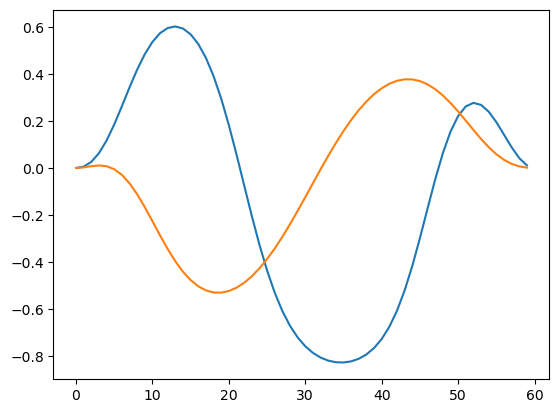

In [53]:
dyn = optim.dynamics
crab_pgen = optim.pulse_generator[0]
# Apply a ramping pulse that will force the start and end to zero
ramp_pgen = pulsegen.create_pulse_gen('GAUSSIAN_EDGE', dyn=dyn, 
                                    pulse_params={'decay_time':evo_time/500.0})
crab_pgen.ramping_pulse = ramp_pgen.gen_pulse()


crab_pgen = optim.pulse_generator[1]
# Apply a ramping pulse that will force the start and end to zero
ramp_pgen = pulsegen.create_pulse_gen('GAUSSIAN_EDGE', dyn=dyn, 
                                    pulse_params={'decay_time':evo_time/500.0})
fff=ramp_pgen.gen_pulse()
crab_pgen.ramping_pulse = fff



init_amps = np.zeros([n_ts, n_ctrls])
for j in range(dyn.num_ctrls):
    pgen = optim.pulse_generator[j]
    pgen.num_coeffs=5
    pgen.init_pulse()
    pgen.freqs=np.random.randint(120,150,pgen.num_coeffs)+np.random.random(pgen.num_coeffs) - 0.5
    init_amps[:, j] = pgen.gen_pulse()
#init_amps=ggg
dyn.initialize_controls(init_amps)
plt.plot(init_amps[:])

In [54]:
# Save initial amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_initial_" + f_ext
    dyn.save_amps(pulsefile)
    print("Initial amplitudes output to file: " + pulsefile)

print("***********************************")
print("Starting pulse optimisation")
result = optim.run_optimization()

# Save final amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_final_" + f_ext
    dyn.save_amps(pulsefile)
    print("Final amplitudes output to file: " + pulsefile)

Initial amplitudes output to file: ctrl_amps_initial_HADAMARD_n_ts_60_3_level.txt
***********************************
Starting pulse optimisation
Final amplitudes output to file: ctrl_amps_final_HADAMARD_n_ts_60_3_level.txt


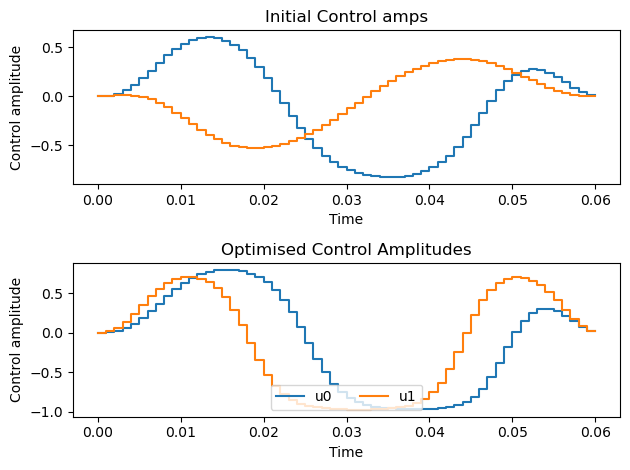

In [55]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial Control amps")
ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax1.step(result.time, 
             np.hstack((result.initial_amps[:, j], result.initial_amps[-1, j])), 
             where='post')
ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Amplitudes")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax2.step(result.time, 
             np.hstack((result.final_amps[:, j], result.final_amps[-1, j])), 
             where='post', label='u{}'.format(j))
ax2.legend(loc=8, ncol=n_ctrls)
plt.tight_layout()
plt.show()


In [56]:
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity {}".format(1-result.fid_err))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(
        datetime.timedelta(seconds=result.wall_time)))

Initial fidelity error 0.4672500585517627
Final fidelity 0.9992647638897121
Terminated due to Function converged (within tolerance)
Number of iterations 571
Completed in 0:00:13.836448 HH:MM:SS.US


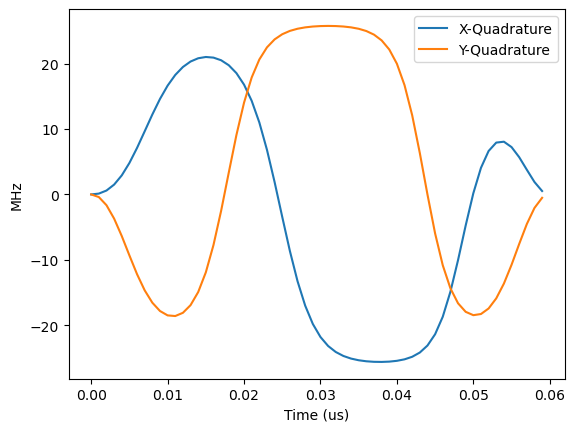

In [4]:
data = np.loadtxt('ctrl_amps_final_HADAMARD_n_ts_60_3_level.txt')
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
data[:,1]=data[:,1]*26.5
data[:,2]=data[:,2]*26.5*(-1)
np.savetxt('ctrl_amps_final_HADAMARD_n_ts_60_3_level(MODIFIED).txt', data, fmt='%f', delimiter='       ', header='Time(us)  MHz', comments='')
plt.plot(data[:,0],data[:,1],label="X-Quadrature")
plt.plot(data[:,0],data[:,2],label="Y-Quadrature")
plt.xlabel("Time (us)")
plt.ylabel("MHz")
plt.legend()

In [26]:
data = np.loadtxt('ctrl_amps_final_HADAMARD_n_ts_60_3_level.txt')
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
data[:,1]=data[:,1]*26.5
data[:,2]=data[:,2]*26.5*-1
data

array([[0.000000, -0.000000, 0.000000],
       [0.001000, 0.128258, -0.402482],
       [0.002000, 0.596311, -1.649010],
       [0.003000, 1.506276, -3.700725],
       [0.004000, 2.915212, -6.369991],
       [0.005000, 4.815659, -9.332134],
       [0.006000, 7.120259, -12.206271],
       [0.007000, 9.662960, -14.676044],
       [0.008000, 12.229114, -16.566925],
       [0.009000, 14.609344, -17.836011],
       [0.010000, 16.651461, -18.507282],
       [0.011000, 18.282933, -18.605385],
       [0.012000, 19.499468, -18.111266],
       [0.013000, 20.335358, -16.939622],
       [0.014000, 20.834459, -14.936831],
       [0.015000, 21.030135, -11.913685],
       [0.016000, 20.934046, -7.740703],
       [0.017000, 20.529736, -2.509571],
       [0.018000, 19.768072, 3.336006],
       [0.019000, 18.563806, 9.079510],
       [0.020000, 16.796177, 14.047650],
       [0.021000, 14.321528, 17.897968],
       [0.022000, 11.010485, 20.645673],
       [0.023000, 6.819430, 22.503641],
       [0.024000,

In [9]:
N = 3
f_1 = 5.03648*(10**3)
f_2 = 4.96961*(10**3)
delta_1 = -268
delta_2 = -269
T1_1 = 25
T1_2 = 37
T2star_1 = 11
T2star_2 = 28
# the lists of variables for all 6 qubits.
f = [f_1, f_2] #the coefficient of the bare hamiltonian for each qubit
delta = [delta_1, delta_2] #the coefficient for the Kerr term
#      33    34     43    44
J = [[ 0.0, 4.25],[4.25, 0.0]]

# defines a_i.
a_1 = tensor(destroy(N), qeye(N))
a_2 = tensor(qeye(N), destroy(N))

a = [a_1, a_2]

# defines the identity matrix
identity_matrix = tensor(qeye(N), qeye(N))
# defines the zero matrix
zero_ = Qobj(np.zeros((N,N)))
zero_matrix = tensor(zero_, zero_)

def HamiltonianQ3(f, delta, J, N):
    
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(2):
        e = (f[i]-f[0])*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + (2*np.pi)*e
       
    # defines the interaction Hamiltonian (the spins are labelled 0-5)
    H_int = zero_matrix
    for i in range(2):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%2])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%2]) + Qobj(a[i])*Qobj(a[(i+1)%2]).dag())
        H_int = H_int + 0*(2*np.pi)*0.5*(p_neighbor_1) #to prevent double counting, we need to multiply by 0.5.  
    
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham

H_dQ3 = HamiltonianQ3(f, delta, J, N)
H_cQ3 = [ 26.5*(2*np.pi)*Qobj(a[0].dag() + a[0])/2,  26.5*(2*np.pi)*Qobj(a[0].dag() - a[0])/(2*1j)]
H_dQ3

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
  0.000000]
 [0.000000 -420.156601 0.000000 0.000000 0.000000 0.000000 0.000000
  0.000000 0.000000]
 [0.000000 0.000000 -2530.490051 0.000000 0.000000 0.000000 0.000000
  0.000000 0.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
  0.000000]
 [0.000000 0.000000 0.000000 0.000000 -420.156601 0.000000 0.000000
  0.000000 0.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 -2530.490051 0.000000
  0.000000 0.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 -1683.893662
  0.000000 0.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
  -2104.050264 0.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
  -4214.383713]]

In [10]:
N=3
from scipy.linalg import expm
import cmath
U=identity(N**2)
#U=Qobj(U.full(),dims=[[N,N],[N,N]])
st=basis(N**2,0)*basis(N**2,0).dag()
fid=[]

for i in range(len(data[:,1])):
    u1=Qobj(expm(-0.001*1j*(H_dQ3.full()+data[:,1][i]*H_cQ3[0].full()/26.5-data[:,2][i]*H_cQ3[1].full()/26.5)))
    U=u1*U
    st=u1*st*u1.dag()
    #plot(Qobj((Qobj(st.full(),dims=[[N,N],[N,N]]).ptrace(0)).full()[:2,:2]),0)
st

Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 5.00001031e-01+2.26598254e-17j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  4.99999447e-01-1.26797999e-05j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -2.99639354e-04-6.80385696e-04j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 4.9

In [11]:
U/(U[0][0]*np.sqrt(2))

Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 7.07106781e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  7.07104780e-01+1.61829474e-05j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   6.52873432e-04-5.83401837e-04j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  7.05030330e-01+5.41501048e-02j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   7.05027096e-01+5.41660870e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  6.95633043e-04-5.31691726e-04j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   3.62238579e-01+6.07275235e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  3.62223656e-01+6.07281807e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   8.35491115e-04+2.61832045e-04j]
 [ 7.

In [12]:
b  = qutip.Bloch()

#Vizualising Blch sphere
#b.make_sphere()
#b.view = [90,0]
b.clear()

In [13]:

# b.make_sphere()
def plot(rho, num):
    eigenvalues, eigenvectors = np.linalg.eig(rho.full())
    idx = eigenvalues.argsort()[::-1]  # Sort by eigenvalue in descending order
    eigenvectors = eigenvectors[:, idx]  # Sort eigenvectors accordingly
    dominant_eigenvector = eigenvectors[:, 0]
    state = Qobj(dominant_eigenvector / np.linalg.norm(dominant_eigenvector))

    bloch_vector = [
        expect(sigmax(), state),
        expect(sigmay(), state),
        expect(sigmaz(), state)
    ]

    if(num==0):
        state=state.full()
        b.add_points(np.array(bloch_vector)[:, np.newaxis], 'm','c')
        b.render()
    #
    else:
        b.add_states(state)
        b.render()

# b.make_sphere()
#rho = Qobj(np.array([[-9,10],[-12,8]]))#this is the input
#plot(rho,0)# if second parameter = 0, it will plot a point, if 1 it will plot a vector
#b.show()

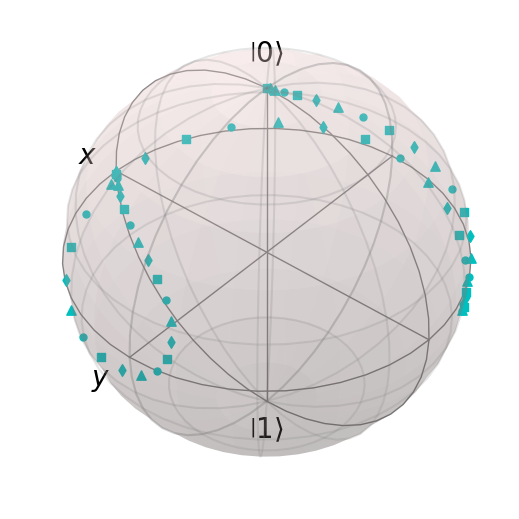

In [16]:
from scipy.linalg import expm
import cmath
U=identity(N**2)
#U=Qobj(U.full(),dims=[[N,N],[N,N]])
st=basis(N**2,0)*basis(N**2,0).dag()
fid=[]

for i in range(len(data[:,1])):
    u1=Qobj(expm(-0.001*1j*(H_dQ3.full()+data[:,1][i]*H_cQ3[0].full()/26.5-data[:,2][i]*H_cQ3[1].full()/26.5)))
    U=u1*U
    st=u1*st*u1.dag()
    plot(Qobj((Qobj(st.full(),dims=[[N,N],[N,N]]).ptrace(0)).full()[:2,:2]),0)
b.show()

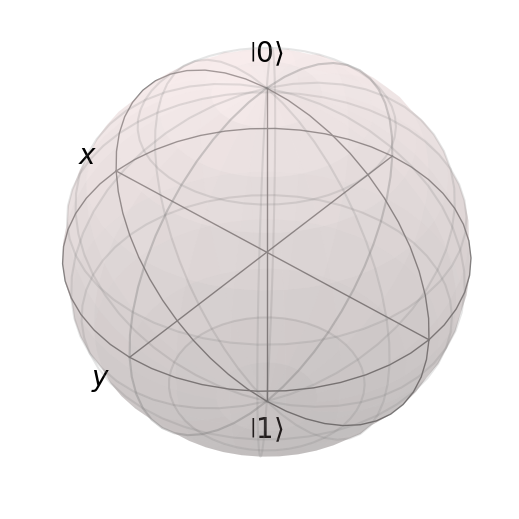

In [15]:
b  = qutip.Bloch()
b.view = [40,40]
b.show()